In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import xgboost as xgb
import time
import pickle

In [2]:
root = "../../../../../"

In [3]:
df = pd.read_csv(root + "datasets/multiclass/processed/CICDDoS_basic.csv", index_col=[0])

In [4]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1.0,2.0,0.0,2736.0,0.0,1368.0,1368.0,1368.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
1,1.0,2.0,0.0,2650.0,0.0,1325.0,1325.0,1325.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
2,2.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
3,46.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
4,1.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS


In [5]:
X = df.drop(columns=[' Label'])
y = df[' Label']

In [6]:
input_features = len(X.columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

___
# Remove correlated features (keeping one of them)

In [8]:
start = time.time()
# Feature Selection
fs_start = time.time()
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat > 0.9]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():    
    if feature not in grouped_feature_ls:
        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
        # append the block of features to the list
        correlated_groups.append(correlated_block)

group_head = []

for group in correlated_groups:
    group_head.append(group.iloc[0,0])

features_to_remove = [feature for feature in grouped_feature_ls if feature not in group_head]

X_train.drop(columns=features_to_remove, inplace=True)
X_test.drop(columns=features_to_remove, inplace=True)
fs_end = time.time()

c:\Users\pedro\miniconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


___
# Training a model

In [9]:
# Training the model
train_start = time.time()
clf_xgb = xgb.XGBClassifier(eval_metric="mlogloss", seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             # verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='logloss',
#             eval_set=[(X_test, y_test)])
clf_xgb.fit(X_train, y_train)
train_end = time.time()
end = time.time()

c:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [10]:
fs_time = (fs_end - fs_start)
train_time = (train_end - train_start)
fit_time = (end - start)

In [11]:
output_features = len(X_train.columns)

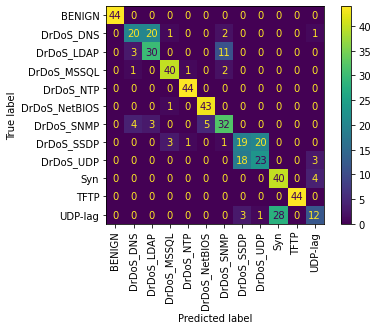

In [12]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      xticks_rotation='vertical')
plt.savefig(root + 'pictures/multiclass_categorical/label_independent/confusion_matrix_corr.pdf', bbox_inches='tight')

In [13]:
y_pred = clf_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average='macro')
f1score = f1_score(y_test, y_pred, average='macro')

In [14]:
pfm = pd.DataFrame(["Correlation", accuracy, precision, recall, f1score,
                    fit_time, fs_time, train_time, input_features, output_features])
pfm = pfm.T
pfm.columns = ["Method", "Accuracy", "Precision", "Recall", "F1_Score", 
                "Fit_Time", "FS_Time", "Train_Time", "Input_Features", "Output_Features"]

filename = root + "pickles/multiclass_categorical/hold_out/label_independent/corr.pkl"
outfile = open(filename, 'wb')
pickle.dump(pfm, outfile)
outfile.close()

In [15]:
print(classification_report(y_test, y_pred, digits=6))

               precision    recall  f1-score   support

       BENIGN   1.000000  1.000000  1.000000        44
    DrDoS_DNS   0.714286  0.454545  0.555556        44
   DrDoS_LDAP   0.566038  0.681818  0.618557        44
  DrDoS_MSSQL   0.888889  0.909091  0.898876        44
    DrDoS_NTP   0.956522  1.000000  0.977778        44
DrDoS_NetBIOS   0.895833  0.977273  0.934783        44
   DrDoS_SNMP   0.666667  0.727273  0.695652        44
   DrDoS_SSDP   0.475000  0.431818  0.452381        44
    DrDoS_UDP   0.522727  0.522727  0.522727        44
          Syn   0.588235  0.909091  0.714286        44
         TFTP   1.000000  1.000000  1.000000        44
      UDP-lag   0.600000  0.272727  0.375000        44

     accuracy                       0.740530       528
    macro avg   0.739516  0.740530  0.728800       528
 weighted avg   0.739516  0.740530  0.728800       528

